In [1]:
!git clone -b features/model/mobilenet --single-branch https://github.com/hanvocado/pneumonia_detection.git
%cd pneumonia_detection
!git status
!git branch

Cloning into 'pneumonia_detection'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 122 (delta 5), reused 21 (delta 5), pack-reused 88 (from 1)
Receiving objects: 100% (122/122), 18.16 MiB | 19.72 MiB/s, done.
Resolving deltas: 100% (36/36), done.
/content/pneumonia_detection
On branch features/model/mobilenet
Your branch is up to date with 'origin/features/model/mobilenet'.

nothing to commit, working tree clean
* features/model/mobilenet


In [2]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 161.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 105.0 MB/s eta 0:00:00


In [3]:
!jupyter nbconvert --to notebook --execute src/preprocess/download_and_preprocess.ipynb --output /content/out_download_and_preprocess.ipynb

[NbConvertApp] Converting notebook src/preprocess/download_and_preprocess.ipynb to notebook
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
[NbConvertApp] Writing 6809213 bytes to /content/out_download_and_preprocess.ipynb


In [4]:
!jupyter nbconvert --to notebook --execute src/preprocess/split_dataset.ipynb \
  --output /content/out_split_dataset.ipynb

[NbConvertApp] Converting notebook src/preprocess/split_dataset.ipynb to notebook
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
[NbConvertApp] Writing 1368664 bytes to /content/out_split_dataset.ipynb


In [5]:
!nvidia-smi

Mon Dec 22 09:39:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os, sys
import time
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np
import torch.nn.functional as F

In [7]:
# CONFIG
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

current_directory = os.getcwd()
while not current_directory.endswith('pneumonia_detection'):
    current_directory = os.path.dirname(current_directory)
root_directory = current_directory
os.chdir(root_directory)
sys.path.insert(0, root_directory)
base_dir = os.path.join(root_directory, 'data_processed_new')

# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 50
EARLY_STOPPING_PATIENCE = 7

# Learning rates (lower for pretrained backbone)
BACKBONE_LR = 1e-4
CLASSIFIER_LR = 1e-3

Device: cuda


In [8]:
# Data transforms with ImageNet normalization (required for pretrained models)
# MobileNetV3 expects RGB images normalized with ImageNet stats
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels for pretrained model
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Load datasets
try:
    train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=train_transforms)
    val_dataset = datasets.ImageFolder(os.path.join(base_dir, 'val'), transform=val_test_transforms)
    test_dataset = datasets.ImageFolder(os.path.join(base_dir, 'test'), transform=val_test_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    print(f"Class mapping: {train_dataset.class_to_idx}")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

except FileNotFoundError:
    print(f"ERROR: Data not found at {base_dir}")

Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
Train samples: 5982
Val samples: 877
Test samples: 880


In [10]:
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)

# Freeze early layers (feature extractor)
for param in model.features[:10].parameters():
    param.requires_grad = False

# Replace classifier for binary classification
num_features = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.Hardswish(),
    nn.Dropout(p=0.3),
    nn.Linear(1024, 2)
)

model = model.to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 164MB/s]


Total parameters: 3,958,066
Trainable parameters: 3,798,114


In [11]:
# Loss function and optimizer with differential learning rates
criterion = nn.CrossEntropyLoss()

# Different learning rates for backbone vs classifier
optimizer = optim.AdamW([
    {'params': model.features.parameters(), 'lr': BACKBONE_LR},
    {'params': model.classifier.parameters(), 'lr': CLASSIFIER_LR}
], weight_decay=1e-4)

# Learning rate scheduler - reduce on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

In [12]:
# TRAINING LOOP
train_losses = []
val_losses = []
val_accuracies = []

# Best model tracking
best_val_acc = 0.0
best_model_path = "models/mobilenetv3_best.pth"
os.makedirs("models", exist_ok=True)

# Early stopping
epochs_without_improvement = 0

print("\nSTARTING TRAINING")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE} epochs")
print(f"Backbone LR: {BACKBONE_LR}, Classifier LR: {CLASSIFIER_LR}")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    # --- TRAINING ---
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- VALIDATION ---
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)

    # Update learning rate scheduler
    scheduler.step(val_acc)

    # Save best model and check early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | Best model saved!")
    else:
        epochs_without_improvement += 1
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | No improvement ({epochs_without_improvement}/{EARLY_STOPPING_PATIENCE})")

    # Early stopping check
    if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

total_time = (time.time() - start_time) / 60
print(f"\nTraining completed in {total_time:.2f} minutes!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Best model saved to: {best_model_path}")


STARTING TRAINING
Early stopping patience: 7 epochs
Backbone LR: 0.0001, Classifier LR: 0.001
Epoch [1/50] | Train Loss: 0.2036 | Val Loss: 0.1186 | Val Acc: 95.78% | Best model saved!
Epoch [2/50] | Train Loss: 0.1002 | Val Loss: 0.1144 | Val Acc: 94.87% | No improvement (1/7)
Epoch [3/50] | Train Loss: 0.0808 | Val Loss: 0.1378 | Val Acc: 95.32% | No improvement (2/7)
Epoch [4/50] | Train Loss: 0.0647 | Val Loss: 0.0752 | Val Acc: 96.92% | Best model saved!
Epoch [5/50] | Train Loss: 0.0465 | Val Loss: 0.1317 | Val Acc: 96.12% | No improvement (1/7)
Epoch [6/50] | Train Loss: 0.0423 | Val Loss: 0.1130 | Val Acc: 96.47% | No improvement (2/7)
Epoch [7/50] | Train Loss: 0.0399 | Val Loss: 0.0991 | Val Acc: 97.49% | Best model saved!
Epoch [8/50] | Train Loss: 0.0358 | Val Loss: 0.0987 | Val Acc: 97.04% | No improvement (1/7)
Epoch [9/50] | Train Loss: 0.0236 | Val Loss: 0.1248 | Val Acc: 97.38% | No improvement (2/7)
Epoch [10/50] | Train Loss: 0.0270 | Val Loss: 0.1280 | Val Acc: 97.

In [13]:
def evaluate_and_visualize(model, loader, device, train_losses, val_losses, val_accuracies):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    # Calculate metrics
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    report = classification_report(all_labels, all_preds, target_names=['NORMAL', 'PNEUMONIA'])
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # PLOT 1: LEARNING CURVE
    epochs_range = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss Value', color=color)
    ax1.plot(epochs_range, train_losses, color=color, marker='o', label='Train Loss')
    ax1.plot(epochs_range, val_losses, color='tab:orange', marker='x', linestyle='--', label='Val Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Accuracy (%)', color=color)
    ax2.plot(epochs_range, val_accuracies, color=color, marker='s', label='Val Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('MobileNetV3 - Learning Curve')
    plt.show()

    # PLOT 2: CONFUSION MATRIX
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'], annot_kws={"size": 16})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Ground Truth', fontsize=12)
    plt.title(f'Confusion Matrix (Test Accuracy: {(tp+tn)/(tp+tn+fp+fn):.2%})', fontsize=14)
    plt.show()

    # PLOT 3: ROC CURVE
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - MobileNetV3', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print("\n" + "="*40)
    print("MODEL PERFORMANCE REPORT")
    print("="*40)
    print(report)
    print("-" * 40)
    print(f"AUC Score: {roc_auc:.4f}")
    print(f"False Negatives (Missed cases): {fn}")
    print(f"False Positives (False alarms): {fp}")
    print("="*40)

Loaded best model from: models/mobilenetv3_best.pth


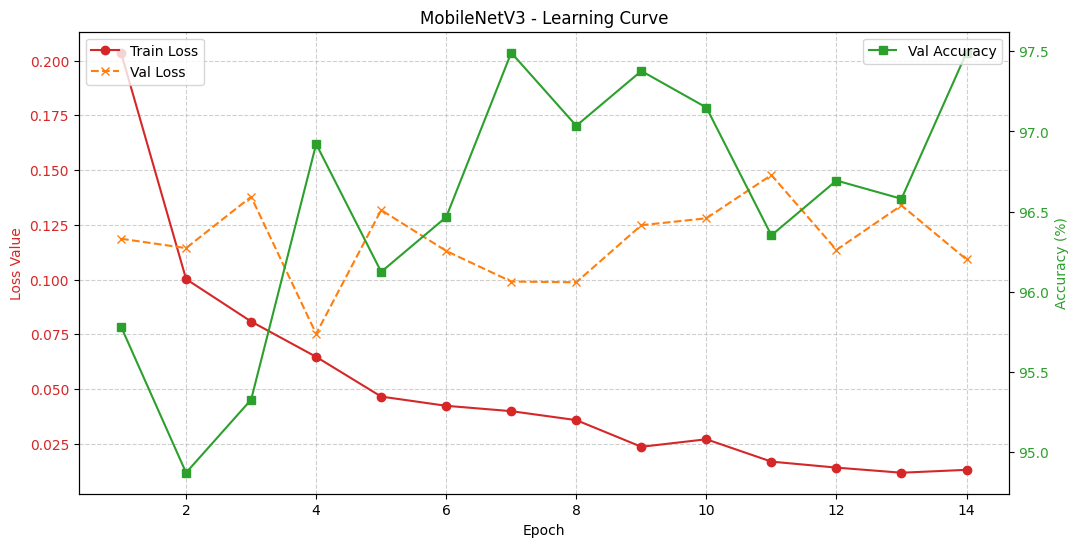

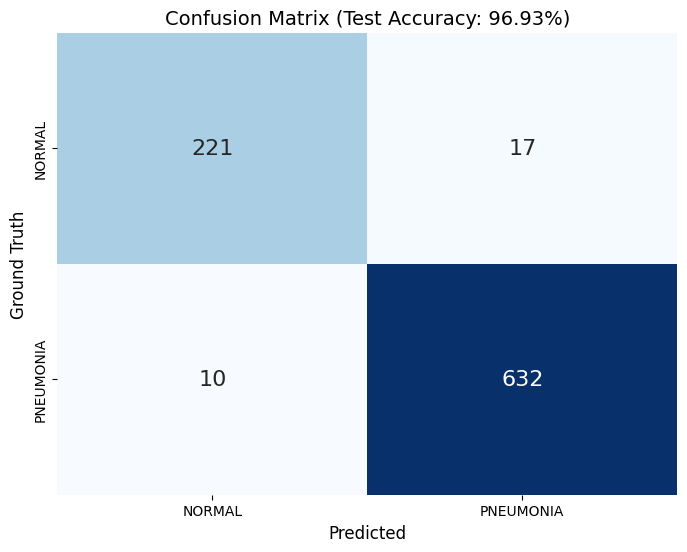

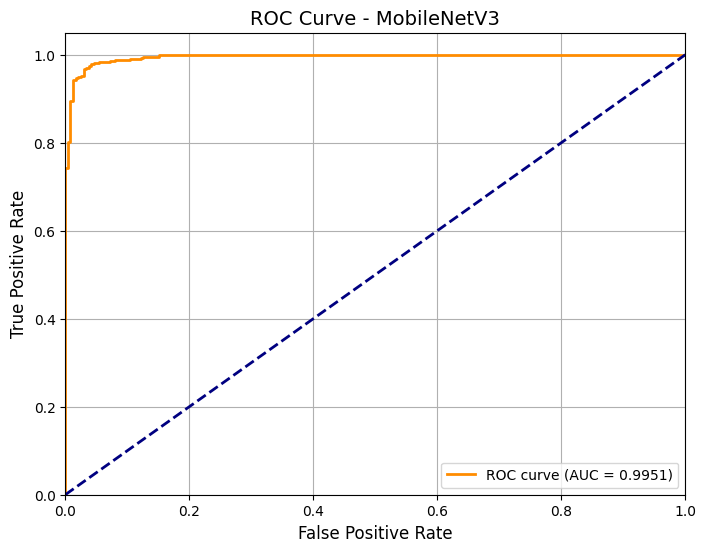


MODEL PERFORMANCE REPORT
              precision    recall  f1-score   support

      NORMAL       0.96      0.93      0.94       238
   PNEUMONIA       0.97      0.98      0.98       642

    accuracy                           0.97       880
   macro avg       0.97      0.96      0.96       880
weighted avg       0.97      0.97      0.97       880

----------------------------------------
AUC Score: 0.9951
False Negatives (Missed cases): 10
False Positives (False alarms): 17


In [14]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from: {best_model_path}")

evaluate_and_visualize(model, test_loader, device, train_losses, val_losses, val_accuracies)